In [15]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
%matplotlib inline 
import numpy as np
import pandas as pd
import sqlite3
import time

In [26]:
patternAr = []
performanceAr = []

In [3]:
def readData(filename, tablename):
    conn = sqlite3.connect(filename)
    c = conn.cursor()
    Dict = []
    sql_command = 'SELECT * FROM ' + tablename
    for row in c.execute(sql_command):
        Dict.append(row)
    data = pd.DataFrame(Dict)
    data.columns = ['index','buy/sell','price','size','ob_level','timestamp']
    data['timestamp'] = pd.to_datetime(data.timestamp)
    bid = data[(data['buy/sell'] == 'buy') & (data['ob_level'] == 1)
               & ((data['index']-1)%200==0)]
    ask = data[(data['buy/sell'] == 'sell') & (data['ob_level'] == 1)
               & ((data['index']-11)%200==0)]
    return bid,ask

bid, ask = readData('okcoin.rdb','okcoin_ob')

In [4]:
avgLine = (np.array(bid['price'])+np.array(ask['price']))/2

In [ ]:
def graphRawFX():
    fig = plt.figure(figsize=(10,7))
    ax1 = plt.subplot2grid((40,40),(0,0),rowspan=40,colspan=40)

    ax1.plot(range(len(bid)),bid['price'], label="bid")
    ax1.plot(range(len(ask)),ask['price'], label="ask")
    ax1.legend()
    plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
    ax1_2 = ax1.twinx()

    ax1_2.fill_between(range(bid.shape[0]),0,(np.array(ask['price'])
                        -np.array(bid['price'])),
                        facecolor='g', alpha=.3)
    
    plt.subplots_adjust(bottom=.23)
    plt.grid(True)
    plt.show()
graphRawFX()

In [5]:
def percentChange(startPoint, currentPoint):
    return ((float(currentPoint)-startPoint)/abs(startPoint))*100.00

In [27]:
def patternStorage(start):
    patStartTime = time.time()

    x = len(avgLine) - 30
    
    y = start
    
    while y < x:
        pattern = []
        for i in xrange(1,start):
            pattern.append(percentChange(avgLine[y-start],
                                          avgLine[y-start+i]))
        outcomeRange = avgLine[y+20:y+30]
        currentPoint = avgLine[y]
        
        try:
            avgOutcome = reduce(lambda x, y: x+y, 
                                outcomeRange / len(outcomeRange))
        except Exception, e:
            print str(e)
            avgOutcome=0
            
            
        futureOutcome = percentChange(currentPoint, avgOutcome)
        patternAr.append(pattern)
        performanceAr.append(futureOutcome)
        y += 1
        
    patEndTime = time.time()
    print len(patternAr)
    print len(performanceAr)
    print "Pattern storage took:", patEndTime - patStartTime, " seconds"

In [28]:
patternStorage(31)

15603
15603
Pattern storage took: 2.52500009537  seconds


In [25]:
def currentRecognition(start, length):
    patForRec = []
    for i in xrange(1,length+1):
        patForRec.append(percentChange(avgLine[-start],
                                       avgLine[-start+i]))
    return patForRec

In [57]:
outcomes = []
sample_size = []
for thresh in xrange(40, 76, 5):
    patterns = 0.
    counter = 0.
    for p in xrange(len(patternAr)-300, len(patternAr)):
        patForRec = patternAr[p]
        outcome = simPatternRecognition(thresh, patForRec)
        if outcome !=0:
            if outcome*performanceAr[p] >0:
                counter += 1.
            patterns += 1
    outcomes.append(counter/patterns)
    sample_size.append(patterns)

In [63]:
print sample_size

[223.0, 197.0, 169.0, 146.0, 120.0, 98.0, 73.0, 48.0]


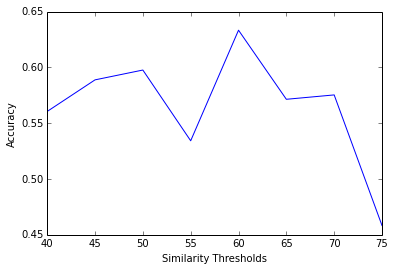

In [64]:
plt.plot(range(40, 76, 5), outcomes)
plt.xlabel("Similarity Thresholds")
plt.ylabel("Accuracy")
plt.show()

In [51]:
def simPatternRecognition(threshold, patForRec):
    #plt.figure()
    # Use similarity to find patterns
    i = 0
    '''
    plt.plot(np.arange(0,len(patForRec)), patForRec)
    '''
    predictions = []
    for eachPattern in patternAr:
        howSim = 0
        for i in xrange(len(patForRec)):
            howSim += 100.0 - abs(percentChange(eachPattern[i], 
                                             patForRec[i]))
        howSim = howSim / len(patForRec)
        if howSim > threshold and howSim < 100:
            patdex = patternAr.index(eachPattern)
            '''
            print "##########################"
            print "##########################"
            
            plt.plot(np.arange(0,len(patForRec)), eachPattern)
            plt.scatter([55],performanceAr[patdex],s=60)
            '''
            predictions.append(performanceAr[patdex])
            '''
            print patForRec
            print "=========================="
            print "=========================="
            print eachPattern
            print "--------------------------"
            print "predicted outcome", performanceAr[patdex]
            print "##########################"
            print "##########################"
            '''
    if len(predictions) == 0:
        return 0
    else:
        return np.mean(predictions)
    '''
    plt.grid(True)
    plt.xlim([0,60])
    plt.show()
    plt.hist(predictions,bins=25)
    plt.show()
    '''

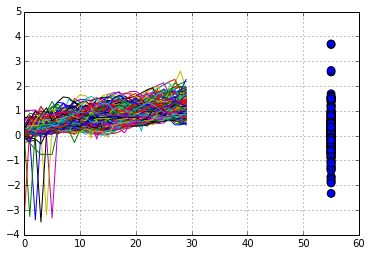

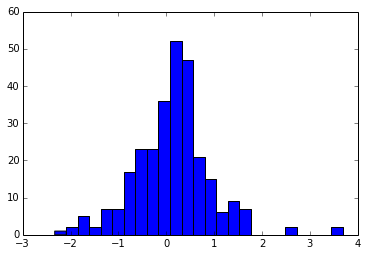

In [22]:
simPatternRecognition(40)

In [14]:
bid.tail()

,index,buy/sell,price,size,ob_level,timestamp
3131800,3131801,buy,4852.01,1.098,1,2014-01-08 00:48:11.971578
3132000,3132001,buy,4858.01,0.097,1,2014-01-08 00:48:56.514502
3132200,3132201,buy,4858.00,0.900,1,2014-01-08 00:49:29.025155
3132400,3132401,buy,4858.00,3.086,1,2014-01-08 00:50:01.566175
3132600,3132601,buy,4876.00,0.750,1,2014-01-08 00:50:51.292260


In [36]:
plt.figure()
plt.scatter([55],[performanceAr[5]])
plt.show()